In [1]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
from mmcd import __version__
from mmseg.datasets import build_dataloader, build_dataset
import torch
import mmcv
from mmcv.parallel import collate, scatter
import numpy as np

Notebook Color Scheme:


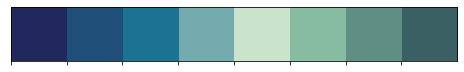

In [2]:
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'happywhale', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[96m'
    E = '\033[0m'
    
my_colors = ["#21295C", "#1F4E78", "#1C7293", "#73ABAF", "#C9E4CA", "#87BBA2", "#618E83", "#3B6064"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.rcParams['font.sans-serif'] = ['SimHei']

plt.rc('font', size=36)#  字体大小设置

In [44]:
from scipy import spatial
 
def cosine_similarity(embeddings):
    # 去掉 第一个轴
    ab = lambda x : np.array([x_ [0] for x_ in x ])
    embeddings = ab(embeddings)
    similarity_matrix = np.dot(embeddings, embeddings.T)
    similarity_matrix = similarity_matrix
    return np.array(similarity_matrix, dtype="float32")


def cal_projection(model,img):
    x = model.extract_feat(img)
    projection1,projection2 = model.auxiliary_head.forward_test(x, None, None)
    return projection1,projection2

def get_cosine_similarity(embeddings):
    '''Compute cos distance between n embedding vector and itself.'''
    similarity_matrix = []
    
    for embed1 in embeddings:
        similarity_row = []
        for embed2 in embeddings:
            # similarity_row.append(1 - spatial.distance.cosine(embed1, embed2)) 
            similarity_row.append(1 - spatial.distance.cosine(embed1.flatten(), embed2.flatten())) 
        similarity_matrix.append(similarity_row)
    
    return np.array(similarity_matrix, dtype="float32")

 
def plot_cosine(projections,example_paths,name,cmap="seismic"):#seismic winter_r
    print(example_paths)
    cos_matrix = get_cosine_similarity(projections)
    mask = np.zeros_like(cos_matrix)
    mask[np.triu_indices_from(mask,k=1)] = False
    # mask =np.ones_like(cos_matrix)
    fig = plt.figure(figsize=(18, 18))
    length = mask.shape[0]
    
    
    # print(mask)
    # mask[np.tril_indices(mask,k=0)] = False
    
    # mask = np.fill_diagonal(mask,1)
    # print(length)
    h_axes=[]
    v_axes=[]
   
    for id_ in range(0,length):
        # print(length, id_+1)
        h_axes.append(plt.subplot2grid(shape=(length+1, length+1), loc=(length, id_+1 ), colspan=1))
        v_axes.append(plt.subplot2grid(shape=(length+1, length+1), loc=(id_, 0), colspan=1))
   
    ax11 = plt.subplot2grid(shape=(length+1, length+1), loc=(0, 1), colspan=length, rowspan=length)
    
    # fig.suptitle('- 余弦相似度 -', size = 21, color = my_colors[7], weight='bold')
    for k, ax in enumerate(h_axes):
        # print(example_paths[k])
        ax.imshow(plt.imread(example_paths[k]))
        ax.set_axis_off()

    for k, ax in enumerate(v_axes):
        # print(example_paths[k])
        ax.imshow(plt.imread(example_paths[k]))
        ax.set_axis_off()

    sns.heatmap(cos_matrix, ax=ax11, fmt=".5",
                cbar=False, annot=True, linewidths=0.5, mask=mask, square=True, cmap=cmap)#winter_r

    plt.tight_layout()
    plt.savefig('{}.png'.format(name)) if name else None
    plt.show()

In [17]:

def func1(config_file,checkpoint_file,data_root= r'../data/samples_LEVIR'):
    # build the model from a config file and a checkpoint file
    model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
    model.eval()
    # test a single image

    cfg = model.cfg
    cfg.data.test.data_root= data_root
    dataset = build_dataset(cfg.data.test)
    loader_cfg = dict(
            # cfg.gpus will be ignored if distributed
            num_gpus=1,
            dist=False,
            shuffle=False)
     # The overall dataloader settings
    loader_cfg.update({
        k: v
        for k, v in cfg.data.items() if k not in [
            'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
            'test_dataloader'
        ]
    })
    test_loader_cfg = {
            **loader_cfg,
            'samples_per_gpu': 1,
            'shuffle': False,  # Not shuffle by default
            **cfg.data.get('test_dataloader', {})
        }

    # build the dataloader
    data_loader = build_dataloader(dataset, **test_loader_cfg)
    loader_indices = data_loader.batch_sampler
    device = next(model.parameters()).device  # model device
    prog_bar = mmcv.ProgressBar(len(dataset))
    projections = [] 
    example_paths = []
    for batch_indices, data in zip(loader_indices, data_loader):
        data = scatter(data, [device])[0]# 关键！！！！
        print(data['img_metas'][0][0]['filename']) 
        with torch.no_grad(): 
            projection1,projection2= cal_projection(model,data['img'][0])
            projections.append(projection1.cpu().numpy())
            projections.append(projection2.cpu().numpy())

            example_paths.append(data['img_metas'][0][0]['filename'][0])
            example_paths.append(data['img_metas'][0][0]['filename'][1])
        prog_bar.update()
            
    return projections,example_paths

In [12]:
checkpoint_file

'/root/mmlight_changedetection/logs/train/runs/2023-05-18_08-29-50/checkpoints/epoch_201_mIoU0.845.ckpt'

In [18]:

config_file = '/root/mmlight_changedetection/logs/train/runs/2023-05-18_08-29-50/MSTACDN_attn_segb0_stm.py'
 
checkpoint_file =  '/root/mmlight_changedetection/logs/train/runs/2023-05-18_08-29-50/checkpoints/epoch_201_mIoU0.845.ckpt'

checkpoint_file_modify =  '/root/mmlight_changedetection/logs/train/runs/2023-05-18_08-29-50/checkpoints/epoch_201_mIoU0.845_addpalette.ckpt'
# 加载模型
ckpt = torch.load(checkpoint_file)
# 检查'meta'键是否存在
if 'meta' in ckpt:
    # 添加属性
    ckpt['meta']['PALETTE'] = 123

    # 保存修改后的模型
    torch.save(ckpt, checkpoint_file_modify)
else:
    print("'meta'键不存在于模型中。")
    
projections,example_paths = func1(config_file,checkpoint_file_modify,data_root= r'/root/mmlight_changedetection/data/CD_Data_GZ_256')  


2023-05-18 10:58:56,538 - mmseg - INFO - Loaded 104 images


load checkpoint from local path: /root/mmlight_changedetection/logs/train/runs/2023-05-18_08-29-50/checkpoints/epoch_201_mIoU0.845_addpalette.ckpt
[                                                  ] 0/104, elapsed: 0s, ETA:['/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test23_2006_1225_Level_18-1-3.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test23_2006_1225_Level_18-1-3.jpg']
[                                 ] 1/104, 1.2 task/s, elapsed: 1s, ETA:    84s['/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test26_2008_1116_Level_18-7-4.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test26_2008_1116_Level_18-7-4.jpg']
[                                 ] 2/104, 2.4 task/s, elapsed: 1s, ETA:    43s['/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test23_2006_1225_Level_18-1-0.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test23_2006_1225_Level_18-1-0.jpg']
[                                 ] 3/104, 3.5 task

In [23]:
projections[:4][0].shape

(1, 64)

['/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test23_2006_1225_Level_18-1-3.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test23_2006_1225_Level_18-1-3.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test12_2011_1223_Level_18-10-4.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test12_2011_1223_Level_18-10-4.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test26_2008_1116_Level_18-5-9.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test26_2008_1116_Level_18-5-9.jpg']


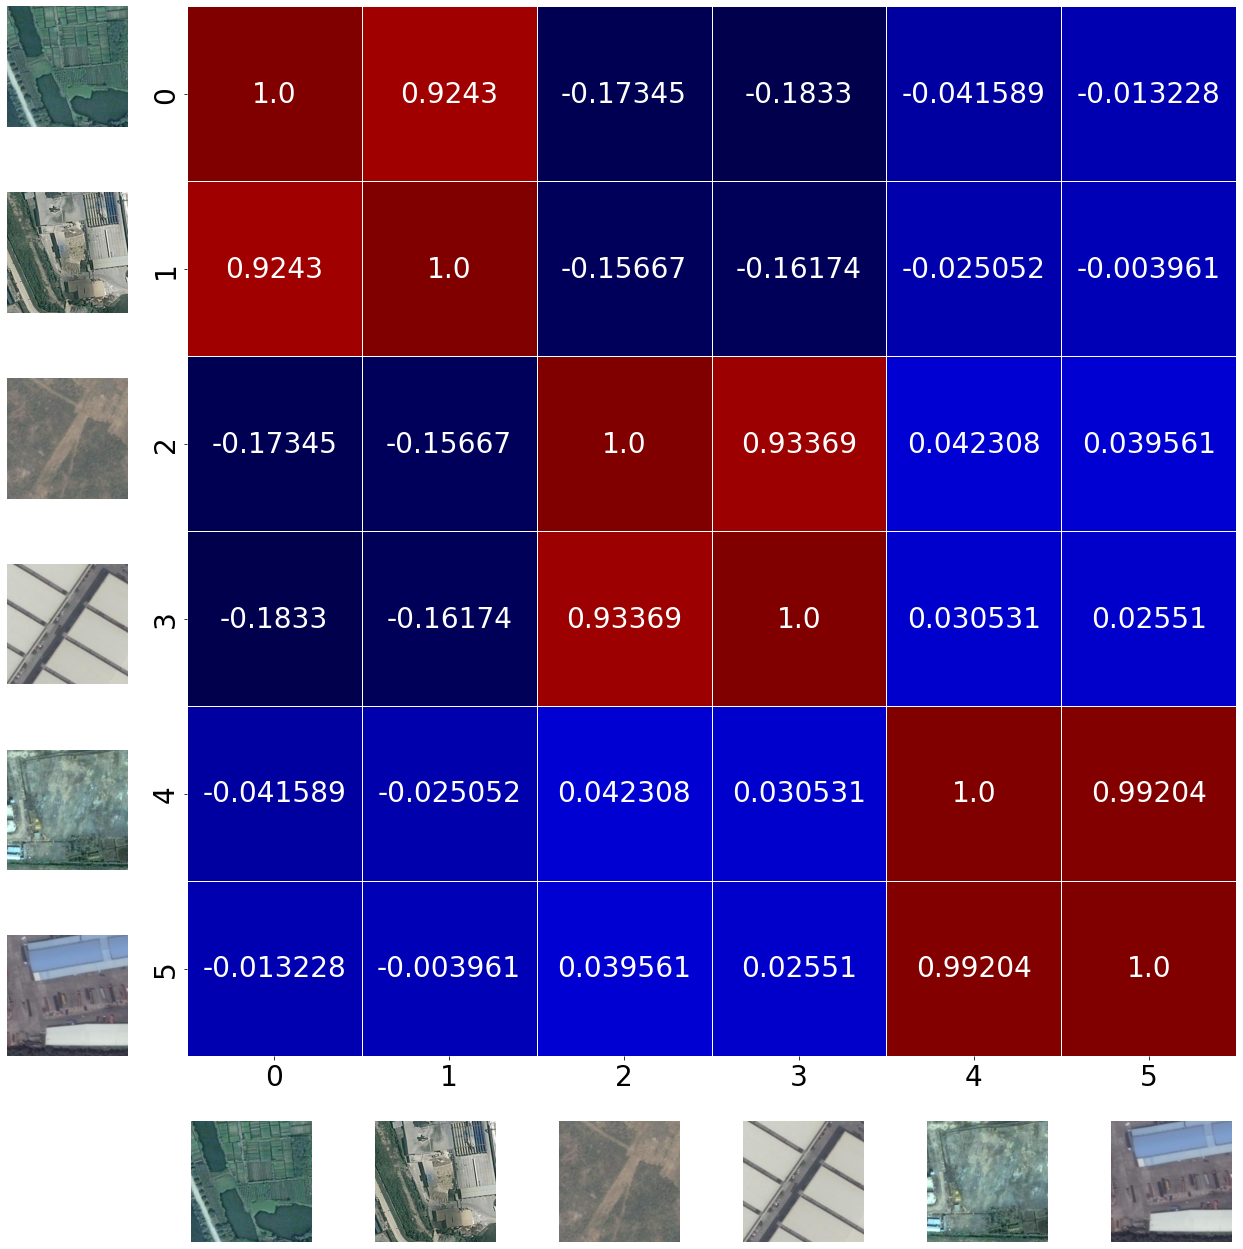

In [54]:
plt.rc('font', size=28)#  字体大小设置
projections_demo = []

projections_demo.append(projections[0])
projections_demo.append(projections[1])
projections_demo.append(projections[8])
projections_demo.append(projections[9])
projections_demo.append(projections[18])
projections_demo.append(projections[19])

example_paths_demo = []
example_paths_demo.append(example_paths[0])
example_paths_demo.append(example_paths[1])
example_paths_demo.append(example_paths[8])
example_paths_demo.append(example_paths[9]) 
example_paths_demo.append(example_paths[18])
example_paths_demo.append(example_paths[19]) 

plot_cosine(projections_demo ,example_paths_demo ,name=r'google_visual.png',cmap="seismic")

# 8-12|0:4
# nums_start = 8
# nums_end = 12
# plot_cosine(projections_demo[nums_start:nums_end],example_paths_demo[nums_start:nums_end],name=None,cmap="seismic")

['/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test13_2013_1126_Level_18-1-2.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test13_2013_1126_Level_18-1-2.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/A/P_GZ_test26_2008_1116_Level_18-5-9.jpg', '/root/mmlight_changedetection/data/CD_Data_GZ_256/B/P_GZ_test26_2008_1116_Level_18-5-9.jpg']


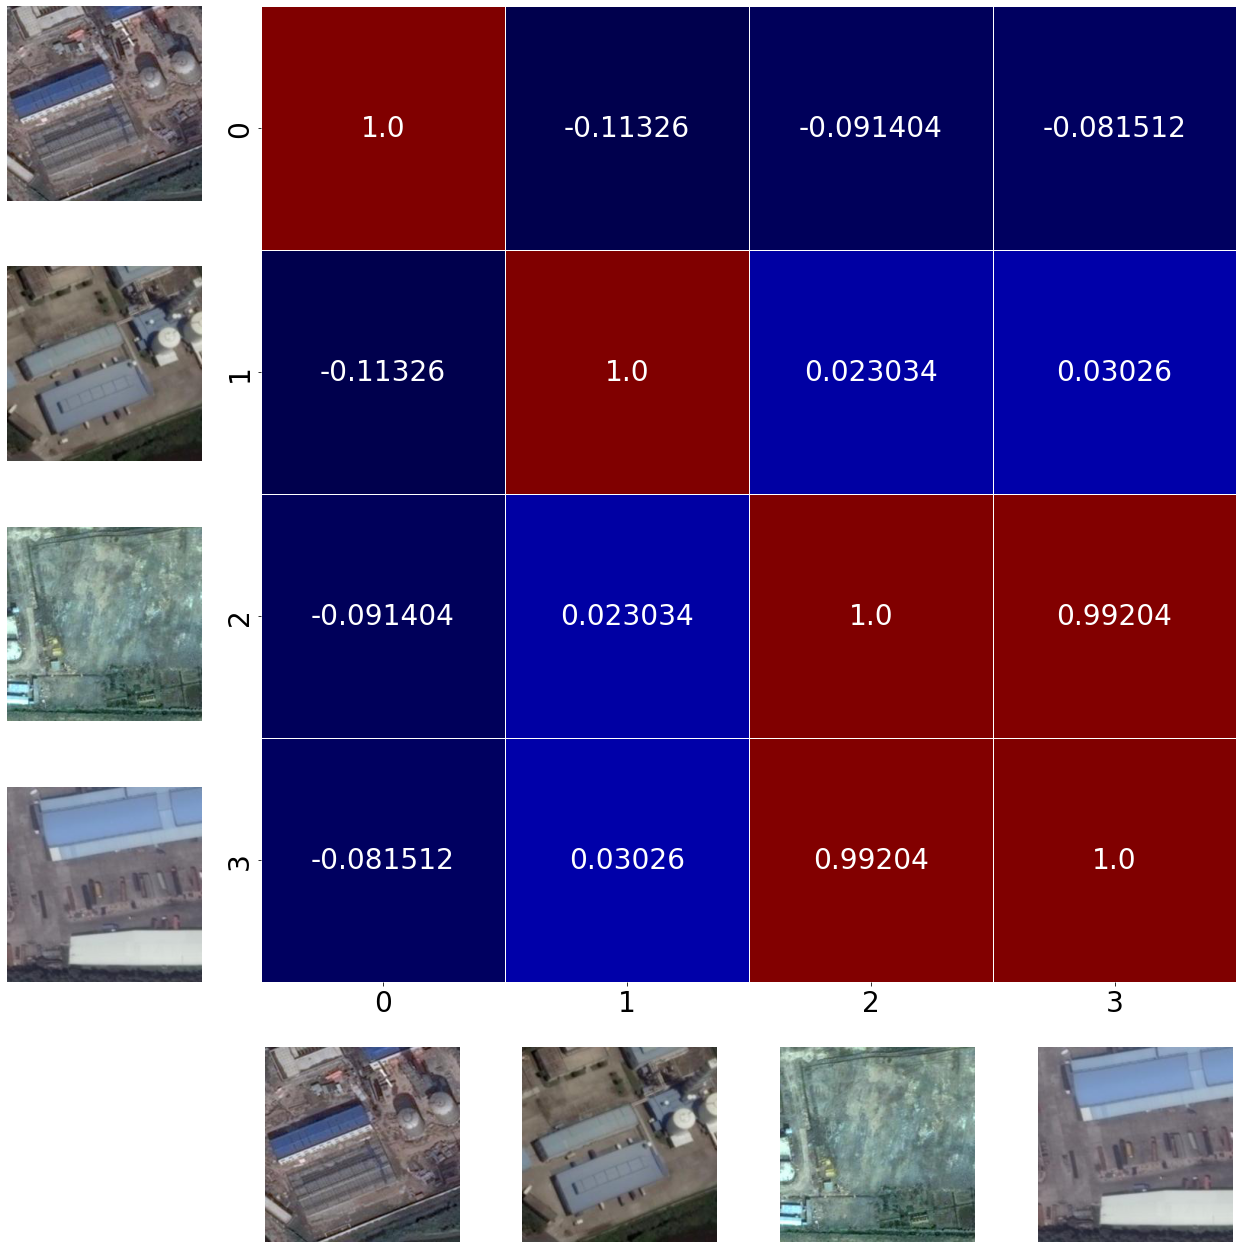

In [52]:
nums_start = 16
nums_end = 20
plot_cosine(projections[nums_start:nums_end],example_paths[nums_start:nums_end],name=None,cmap="seismic")